In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [2]:
#File path
FILE_PATH='/kaggle/input/llm-detect-ai-generated-text'

#Reading files
df_text=pd.read_csv(os.path.join(FILE_PATH,'train_essays.csv'))
df_prompt=pd.read_csv(os.path.join(FILE_PATH,'train_prompts.csv'))

In [3]:
#The training set...
df_train=pd.merge(df_text,df_prompt,how='inner').drop(['prompt_id','id','source_text'],axis=1)

In [4]:
df_train

,text,generated,prompt_name,instructions
0,Cars. Cars have been around since they became ...,0,Car-free cities,Write an explanatory essay to inform fellow ci...
1,Transportation is a large necessity in most co...,0,Car-free cities,Write an explanatory essay to inform fellow ci...
2,"""America's love affair with it's vehicles seem...",0,Car-free cities,Write an explanatory essay to inform fellow ci...
3,How often do you ride in a car? Do you drive a...,0,Car-free cities,Write an explanatory essay to inform fellow ci...
4,Cars are a wonderful thing. They are perhaps o...,0,Car-free cities,Write an explanatory essay to inform fellow ci...
...,...,...,...,...
1373,The Electoral College was originally establish...,0,Does the electoral college work?,Write a letter to your state senator in which ...
1374,"Dear senator, I think that the presidential el...",0,Does the electoral college work?,Write a letter to your state senator in which ...
1375,The electoral college is a group of electors t...,0,Does the electoral college work?,Write a letter to your state senator in which ...
1376,An electoral College compromises between elect...,0,Does the electoral college work?,Write a letter to your state senator in which ...


In [5]:
# Tensorflow imports
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')


#Model Definition
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

#Model and Preprocessor Loading 
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [6]:
#Model PreProcessor testing
text_test = ['I want to feed on your brain']
text_preprocessed = bert_preprocess_model(text_test)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1045 2215 2000 5438 2006 2115 4167  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
#Model testing
bert_results = bert_model(text_preprocessed)
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')


Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9962354   0.6749504  -0.16860026  0.36463147  0.53495365  0.96207964
  0.9170803  -0.9725614  -0.45046052 -0.99990714  0.16068594 -0.9968365 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.8511489   0.13193479  0.11668248 ... -1.3676022   1.1832701
   0.3424835 ]
 [ 0.48370087  0.8548999   0.08391201 ... -0.6279737   0.47634465
  -0.08793321]
 [ 0.8594332  -0.19526523 -1.588242   ...  0.06786477  0.4919755
  -0.26064634]
 ...
 [ 0.295498   -0.4739734  -0.47832587 ... -0.02561095  1.2529026
   0.49825054]
 [ 0.14580213 -0.3988193  -0.16228908 ...  0.24551383  1.2885386
   0.2941185 ]
 [-0.07125125 -0.22631668 -0.13986346 ... -0.4194815   1.0715625
   0.2911302 ]]


In [8]:
#Building the Neural Network
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

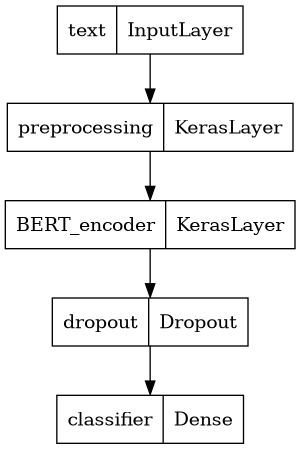

In [9]:
tf.keras.utils.plot_model(build_classifier_model())